<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/8_14_naver_movie(kogpt2_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Aug 11 06:22:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 344 kB 5.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595730 sha256=bc826c4607b02268e452ab20ae921d9bfc62abc42a6471a271a0c3e6e7119c1d
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 2.6 MB 5.0 MB/s 
     |████████████████████████████████| 636 kB 56.2 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 
     |████████████████████████████████| 895 kB 58.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.0 MB/s 


In [ ]:
# -*- coding: utf-8 -*-
"""8-14.naver_movie(kogpt2_2).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1oz7cwQ6Wv116SfshytDb3w68i_oaK7W6
"""

# KoGPT2를 이용한 네이버 영화 감성분석
# 참고 : https://github.com/SKT-AI/KoGPT2
# !pip install --upgrade mxnet>=1.6.0
# !pip install gluonnlp
# !pip install transformers
# !pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
# %cd '/content/drive/MyDrive/Colab Notebooks'
df = pd.read_csv('/content/drive/MyDrive/머신러닝/GPT/naver_ratings.txt', header=0, delimiter='\t', quoting=3)
df = df.dropna()
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
# "\d+"는 숫자 1개 이상을 의미함. 모든 숫자를 공백으로 치환
df['document'] = df['document'].apply(lambda x: re.sub(r"\d+", " ", x))
df.drop('id', axis = 1, inplace = True)

In [ ]:
document = list(df['document'])
label = list(df['label'])
dx_train, dx_test, dy_train, dy_test = train_test_split(document, label, test_size=0.2)

In [ ]:
MY_PATH = '/content/drive/MyDrive/머신러닝/GPT/gpt_ckpt/'
MODEL_PATH = MY_PATH 
TOKENIZER_PATH = MY_PATH + 'gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [ ]:
MAX_LEN = 60

def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]   # 시작 = <s>
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]  # 끝 = </s>

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)

# 시험용으로 100개씩만 사용한다.
x_train, y_train = build_data(dx_train[:100], dy_train[:100])
x_test, y_test = build_data(dx_test[:100], dy_test[:100])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_test[0]

len(x_test[0])

print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])

50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [ ]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]

'▁전세'

In [ ]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
sub_word = tokenizer('나는 자연어처리를 공부하고 있다')
print(sub_word)

['▁나는', '▁자연', '어', '처리를', '▁공부하고', '▁있다']


In [ ]:
sent_idx = vocab[sub_word]
print(sent_idx)

print(detokenizer(sub_word))

print([idx2word[i] for i in x_test[0]])

[3918, 1582, 47487, 29455, 36076, 123]
나는 자연어처리를 공부하고 있다
['<s>', '▁지금까지', '▁미국이', '▁내', '머리', '속을', '▁지배', '했다는', '생각', '에', '▁화가', '난다', '...', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [ ]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/머신러닝/GPT/gpt_ckpt/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = False
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0

Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)  # <s>와 </s> 2개 포함

# GPT2 출력
# ---------
# for classification
# output_gpt[0]           --> <KerasTensor: shape=(None, 62, 50000) dtype=float32
# output_gpt[0][:, -1, :] --> <KerasTensor: shape=(None, 50000) dtype=float32
#
# output_gpt 전체 출력 :
# TFCausalLMOutputWithPast([('logits',
#                            <KerasTensor: shape=(None, 62, 50000) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>),
#                           ('past_key_values',
#                            (<KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>,
#                             <KerasTensor: shape=(2, None, 12, 62, 64) dtype=float32 (created by layer 'tfgp_t2lm_head_model')>))])
# past_key_values : 중간 출력
# (2, None, 12, 62, 64)
# 2 : Text prediction과 Task classifier (GPT-1 논문의 figure-1)
# None : batch
# 12 : number of layers
# 62 : MAX_LEN
# 64 : d_model / num_heads = 768 / 12 = 64 = dk <-- multi-head attention의 각 head의 출력
#      64개 head를 concat으로 묶으면 768 embedding vector size.
#
# https://opensourcelibs.com/lib/kogpt2#mxnet-gluon
# GPT2Model(units=768,
#     max_length=1024,
#     num_heads=12,
#     num_layers=12,
#     dropout=0.1,
#     vocab_size=50000)
output_gpt = gpt_model(x_input)

# 'past_key_values' 출력을 이용한다.
# 마지막 layer의 multi head attension 출력
output_mha = output_gpt[1][0][0, :, -1, :, :]
for i in range(1, 12):
    output_mha = Concatenate()([output_mha, output_gpt[1][i][0, :, -1, :, :]])
output_mha = GlobalAveragePooling1D()(output_mha)

# Downstream task : 네이버 영화 감성분석
# -------------------------------------
y_output = Dense(1, activation = 'sigmoid')(output_mha)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001))
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=1024)

# 1/1 [==============================] - 14s 14s/step - loss: 0.7251 - val_loss: 70.8553
# Epoch 2/3
# 1/1 [==============================] - 1s 1s/step - loss: 69.2513 - val_loss: 26.5999
# Epoch 3/3
# 1/1 [==============================] - 1s 1s/step - loss: 25.5047 - val_loss: 21.4767

Epoch 1/3
1/1 [==============================] - 17s 17s/step - loss: 0.8697 - val_loss: 0.7157
Epoch 2/3
1/1 [==============================] - 0s 438ms/step - loss: 0.7105 - val_loss: 0.7475
Epoch 3/3
1/1 [==============================] - 0s 437ms/step - loss: 0.7109 - val_loss: 0.8215


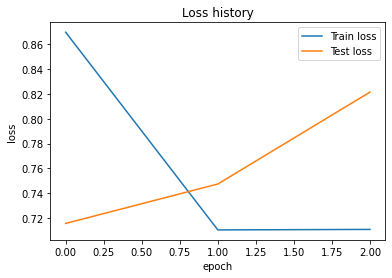

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 46.00 %


In [ ]:
# gpt_model.trainable = True로 바꾸고, learning-rate를 작게 적용해서
# 전체를 다시 학습한다. (미세 조정)